In [1]:
from cerebralcortex import Kernel
import json
import pickle
# from IPython.display import display
# import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from datetime import datetime, timedelta
import random
from cerebralcortex.core.datatypes import DataStream
from cerebralcortex.core.metadata_manager.stream.metadata import Metadata, DataDescriptor, ModuleMetadata
from cerebralcortex.core.util.spark_helper import get_or_create_sc
import ipywidgets as widgets


init_notebook_mode(connected=True)
pd.set_option('display.max_rows',5)

In [2]:
import pyspark.sql.functions as F
from pyspark.sql.types import *

In [3]:
CC = Kernel("/home/jupyter/cc3_conf/", study_name='mperf')

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42175)
Traceback (most recent call last):
  File "/cerebralcortex/kessel_jupyter_virtualenv/cc3_high_performance/lib/python3.6/site-packages/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/cerebralcortex/kessel_jupyter_virtualenv/cc3_high_performance/lib/python3.6/site-packages/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:42175)

In [4]:
CC.search_stream('gyro')

['/cc3/study=mperf/gyroscope--org.md2k.motionsense--motion_sense_hrv--left_wrist',
 '/cc3/study=mperf/gyroscope--org.md2k.motionsense--motion_sense_hrv--right_wrist',
 '/cc3/study=mperf/gyroscope--org.md2k.phonesensor--phone']

In [5]:
accelerometer_right_wrist_stream_name = 'accelerometer--org.md2k.motionsense--motion_sense_hrv--right_wrist'
gyroscope_right_wrist_stream_name = 'gyroscope--org.md2k.motionsense--motion_sense_hrv--right_wrist'

In [6]:
# user_id = CC.list_users()[0]['user_id']
user_id = CC.get_user_id('mperf_1000')
user_name = CC.get_user_name(user_id)

In [7]:
accel_ds = CC.get_stream(accelerometer_right_wrist_stream_name, user_id=user_id).filter("accelerometer_x >= -4 AND accelerometer_x <= 4 AND accelerometer_y >= -4 AND accelerometer_y <= 4 AND accelerometer_z >= -4 AND accelerometer_z <= 4")

In [8]:
gyro_ds = CC.get_stream(gyroscope_right_wrist_stream_name, user_id=user_id).filter("gyroscope_x >= -250 AND gyroscope_x <= 250 AND gyroscope_y >= -250 AND gyroscope_y <= 250 AND gyroscope_z >= -250 AND gyroscope_z <= 250")

In [9]:
accel_w = accel_ds.window(windowDuration=20)
gyro_w = gyro_ds.window(windowDuration=20)

In [10]:
gyro_w = gyro_w.drop("version", "user")

In [11]:
common_ds = accel_w.join(gyro_w, on="window")

In [12]:
common_ds = common_ds.withColumn('timestamp', F.udf(lambda w: w[0], TimestampType())('window')).drop('window')

In [13]:
def is_correct_accel_data(data):
#     data = np.array([accel_x, accel_y, accel_z]).T
    mg = np.mean([np.linalg.norm(x) for x in data])
    if mg < 0.8:
        return 0
    return 1
udf_is_correct_accel_data = F.udf(is_correct_accel_data, IntegerType())

def correct_accel(data, is_correct):
    if is_correct == 1:
        return data
    data = np.array(data)*2
    return data.tolist()
udf_correct_accel = F.udf(correct_accel, ArrayType(DoubleType()))


In [34]:
# schema = StructType([StructField("timestamp", TimestampType()), StructField("accel", ArrayType(ArrayType(DoubleType()))), StructField("gyro", ArrayType(ArrayType(DoubleType())))])
schema = StructType([StructField("count", IntegerType())])
@F.pandas_udf(schema, F.PandasUDFType.GROUPED_MAP)
def get_data_count_udf(user_data):
#     if len(user_data.index) < 600:
#         return pd.DataFrame([], columns=['timestamp', 'accel', 'gyro'])
    is_movement = []
    correct_data = []
    for index, row in user_data.iterrows():
        al = len(row['accelerometer_x'])
        gl = len(row['gyroscope_x'])
        if al<400:  # 25 * 20 * 60% (frequency * window_size * threshold%)
            is_movement.append(0)
            correct_data.append(1)
            continue
    
        accel_data = np.array([*row['accelerometer_x'], *row['accelerometer_y'], *row['accelerometer_z']])
        
        accel_data = accel_data.reshape(-1, al)
        accel_data = accel_data.T
        if not is_correct_accel_data(accel_data):
            ax = 2*np.array(row['accelerometer_x']).tolist()
            ay = 2*np.array(row['accelerometer_y']).tolist()
            az = 2*np.array(row['accelerometer_z']).tolist()
            accel_data = np.array([*ax, *ay, *az])
            accel_data = accel_data.reshape(-1, al)
            accel_data = accel_data.T
            correct_data.append(0)
        else:
            correct_data.append(1)
        mg = [np.linalg.norm(x) for x in accel_data]
        sd= np.std(mg)
        if sd >= 0.21:
            is_movement.append(1)
        else:
            is_movement.append(0)
    user_data['is_movement'] = is_movement
    user_data['correct'] = correct_data
    data_movement = user_data[user_data['is_movement']==1]
    return pd.DataFrame(data={'count':[len(data_movement.index)]})
#     if len(data_movement.index) < 600:
#         return pd.DataFrame([], columns=['timestamp', 'accel', 'gyro'])
#     leap = 1# int(np.floor(len(data_movement.index) / 600))
#     ts = []
#     adt = []
#     gdt = []
#     for i in range(0, len(data_movement.index), leap):
#         row = data_movement.iloc[i]
#         al = len(row['accelerometer_x'])
#         gl = len(row['gyroscope_x'])
#         ts.append(row['timestamp'])
#         if row['correct']==1:
#             accel_data = np.array([*row['accelerometer_x'], *row['accelerometer_y'], *row['accelerometer_z']])
#         else:
#             ax = 2*np.array(row['accelerometer_x']).tolist()
#             ay = 2*np.array(row['accelerometer_y']).tolist()
#             az = 2*np.array(row['accelerometer_z']).tolist()
#             accel_data = np.array([*ax, *ay, *az])
                                   
#         gyro_data = np.array([*row['gyroscope_x'], *row['gyroscope_y'], *row['gyroscope_z']])
#         accel_data = accel_data.reshape(-1, al)
#         gyro_data = gyro_data.reshape(-1, gl)
#         accel_data = accel_data.T
#         gyro_data = gyro_data.T
        
#         adt.append(accel_data.tolist())
#         gdt.append(gyro_data.tolist())
#         if len(ts)>=600:
#             break
#     return pd.DataFrame(data={'timestamp': ts, 'accel': adt, 'gyro': gdt})

In [41]:
schema = StructType([StructField("timestamp", TimestampType()), StructField("accel", ArrayType(ArrayType(DoubleType()))), StructField("gyro", ArrayType(ArrayType(DoubleType())))])
# schema = StructType([StructField("count", IntegerType())])
@F.pandas_udf(schema, F.PandasUDFType.GROUPED_MAP)
def get_data_udf(user_data):
#     if len(user_data.index) < 600:
#         return pd.DataFrame([], columns=['timestamp', 'accel', 'gyro'])
    is_movement = []
    correct_data = []
    for index, row in user_data.iterrows():
        al = len(row['accelerometer_x'])
        gl = len(row['gyroscope_x'])
        if al<400:  # 25 * 20 * 60% (frequency * window_size * threshold%)
            is_movement.append(0)
            correct_data.append(1)
            continue
    
        accel_data = np.array([*row['accelerometer_x'], *row['accelerometer_y'], *row['accelerometer_z']])
        
        accel_data = accel_data.reshape(-1, al)
        accel_data = accel_data.T
        if not is_correct_accel_data(accel_data):
            ax = 2*np.array(row['accelerometer_x']).tolist()
            ay = 2*np.array(row['accelerometer_y']).tolist()
            az = 2*np.array(row['accelerometer_z']).tolist()
            accel_data = np.array([*ax, *ay, *az])
            accel_data = accel_data.reshape(-1, al)
            accel_data = accel_data.T
            correct_data.append(0)
        else:
            correct_data.append(1)
        mg = [np.linalg.norm(x) for x in accel_data]
        sd= np.std(mg)
        if sd >= 0.21:
            is_movement.append(1)
        else:
            is_movement.append(0)
    user_data['is_movement'] = is_movement
    user_data['correct'] = correct_data
    data_movement = user_data[user_data['is_movement']==1]
    current = len(data_movement.index)
    
    if len(data_movement.index) == 0:
        return pd.DataFrame([], columns=['timestamp', 'accel', 'gyro'])
#     leap = 1# int(np.floor(len(data_movement.index) / 600))
    ts = []
    adt = []
    gdt = []
    tot = int(np.ceil(len(data_movement.index)*600/user_data['Available'].iloc[0]))
    for i in range(len(data_movement.index)):
        row = data_movement.iloc[i]
        al = len(row['accelerometer_x'])
        gl = len(row['gyroscope_x'])
        ts.append(row['timestamp'])
        if row['correct']==1:
            accel_data = np.array([*row['accelerometer_x'], *row['accelerometer_y'], *row['accelerometer_z']])
        else:
            ax = 2*np.array(row['accelerometer_x']).tolist()
            ay = 2*np.array(row['accelerometer_y']).tolist()
            az = 2*np.array(row['accelerometer_z']).tolist()
            accel_data = np.array([*ax, *ay, *az])
                                   
        gyro_data = np.array([*row['gyroscope_x'], *row['gyroscope_y'], *row['gyroscope_z']])
        accel_data = accel_data.reshape(-1, al)
        gyro_data = gyro_data.reshape(-1, gl)
        accel_data = accel_data.T
        gyro_data = gyro_data.T
        
        adt.append(accel_data.tolist())
        gdt.append(gyro_data.tolist())
        if len(ts)>=tot:
            break
    return pd.DataFrame(data={'timestamp': ts, 'accel': adt, 'gyro': gdt})

In [36]:
windowDuration = "1 day"
groupbycols = ["user", "version"]

win = F.window("timestamp", windowDuration=windowDuration)

groupbycols.append(win)

count_data = common_ds._data.groupBy(groupbycols).apply(get_data_count_udf)

In [37]:
total = count_data.agg(F.sum("count")).collect()[0][0]

In [40]:
common_ds = common_ds.withColumn('Available', F.lit(total))

In [42]:
data = common_ds._data.groupby(groupbycols).apply(get_data_udf)

In [43]:
pdf = data.toPandas()

In [49]:
pdf.to_csv('data/'+user_name+'.csv.gz', compression='gzip', index=False)

In [74]:
pdf2 = pd.read_csv('data/mperf_1012.csv.gz')

In [75]:
len(pdf2.index)

618

In [15]:
pdf = test_df.toPandas()

AttributeError: 'list' object has no attribute 'toPandas'

In [19]:
test.show(1, truncate=False)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
dt = test.collect()

Py4JJavaError: An error occurred while calling o209.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Total size of serialized results of 196 tasks (1038.3 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:1979)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1967)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1966)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1966)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:946)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:946)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:946)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2196)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2145)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2134)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:748)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2095)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2116)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2135)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2160)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1004)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1003)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:381)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3245)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3407)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$4(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:87)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3403)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3242)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [17]:
2

2

In [16]:
pdf = data.toPandas()

In [19]:
pdf2 = pdf[pdf['count']!=0]

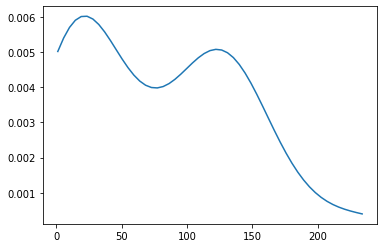

In [30]:
kde = gaussian_kde(pdf2['count'])
x_range = np.linspace(min(pdf2['count']), max(pdf2['count']), len(pdf2['count']))
plt.plot(x_range, kde(x_range) )


In [33]:
pdf2['count'].std()

60.48378376634318

In [80]:
pdf.to_csv("data/"+user_id+".csv", index=False)

In [88]:
pdf.to_csv('data/'+user_id+".csv.gz", compression='gzip')

In [82]:
pd.read_csv("data/"+user_id+".csv")

,timestamp,data
0,2017-12-15 05:58:40,"[[-0.0728759765625, -0.072265625, -0.072631835..."
1,2017-12-15 15:11:40,"[[0.3101806640625, 0.325439453125, 0.315429687..."
...,...,...
10798,2017-12-05 14:43:20,"[[-0.563232421875, -0.57177734375, -0.61608886..."
10799,2017-12-05 14:56:00,"[[0.36474609375, 0.3912353515625, 0.3955078125..."


In [130]:
fake = [[datetime.now()]*1000, [[1]*5]*900+[[0.7]*5]*100, [[2]*5]*900+[[0.7]*5]*100, [[3]*5]*900+[[0.7]*5]*100, [[5]*5]*900+[[10]*5]*100,[[6]*5]*900+[[10]*5]*100, [[7]*5]*900+[[10]*5]*100]

In [131]:
test_df = pd.DataFrame(data={'timestamp': fake[0], 'accelerometer_x': fake[1], 'accelerometer_y': fake[2], 'accelerometer_z': fake[3], 'gyroscope_x': fake[4], 'gyroscope_y': fake[5], 'gyroscope_z': fake[6]})

In [132]:
test_df

,timestamp,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z
0,2019-12-10 04:22:07.164561,"[1, 1, 1, 1, 1]","[2, 2, 2, 2, 2]","[3, 3, 3, 3, 3]","[5, 5, 5, 5, 5]","[6, 6, 6, 6, 6]","[7, 7, 7, 7, 7]"
1,2019-12-10 04:22:07.164561,"[1, 1, 1, 1, 1]","[2, 2, 2, 2, 2]","[3, 3, 3, 3, 3]","[5, 5, 5, 5, 5]","[6, 6, 6, 6, 6]","[7, 7, 7, 7, 7]"
...,...,...,...,...,...,...,...
998,2019-12-10 04:22:07.164561,"[0.7, 0.7, 0.7, 0.7, 0.7]","[0.7, 0.7, 0.7, 0.7, 0.7]","[0.7, 0.7, 0.7, 0.7, 0.7]","[10, 10, 10, 10, 10]","[10, 10, 10, 10, 10]","[10, 10, 10, 10, 10]"
999,2019-12-10 04:22:07.164561,"[0.7, 0.7, 0.7, 0.7, 0.7]","[0.7, 0.7, 0.7, 0.7, 0.7]","[0.7, 0.7, 0.7, 0.7, 0.7]","[10, 10, 10, 10, 10]","[10, 10, 10, 10, 10]","[10, 10, 10, 10, 10]"


In [133]:
# schema = StructType([StructField("timestamp", TimestampType()), StructField("accel", ArrayType(ArrayType(DoubleType()))), StructField("gyro", ArrayType(ArrayType(DoubleType())))])
# schema = StructType([StructField("timestamp", TimestampType()), StructField("data", IntegerType())])
# @F.pandas_udf(schema, F.PandasUDFType.GROUPED_MAP)
def get_data_test(user_data):
    is_movement = []
    correct_data = []
    for index, row in user_data.iterrows():
        al = len(row['accelerometer_x'])
        gl = len(row['gyroscope_x'])
#         if al<300:  # 25 * 20 * 60% (frequency * window_size * threshold%)
#             is_movement.append(0)
#             correct_data.append(1)
#             continue
    
        accel_data = np.array([*row['accelerometer_x'], *row['accelerometer_y'], *row['accelerometer_z']])
        
        accel_data = accel_data.reshape(-1, al)
        accel_data = accel_data.T
        if not is_correct_accel_data(accel_data):
            ax = 2*np.array(row['accelerometer_x']).tolist()
            ay = 2*np.array(row['accelerometer_y']).tolist()
            az = 2*np.array(row['accelerometer_z']).tolist()
            accel_data = np.array([*ax, *ay, *az])
            accel_data = accel_data.reshape(-1, al)
            accel_data = accel_data.T
            correct_data.append(0)
        else:
            correct_data.append(1)
        mg = [np.linalg.norm(x) for x in accel_data]
        sd= np.std(mg)
        if sd >= 0:
            is_movement.append(1)
        else:
            is_movement.append(0)
    user_data['is_movement'] = is_movement
    user_data['correct'] = correct_data
    data_movement = user_data[user_data['is_movement']==1]
#     if len(data_movement.index) < 900:
#         return pd.DataFrame([], columns=['timestamp', 'data'])
#     leap = int(np.floor(len(data_movement.index) / 900))
    leap = 1
    ts = []
    adt = []
    gdt = []
    for i in range(0, len(data_movement.index), leap):
        row = data_movement.iloc[i]
        al = len(row['accelerometer_x'])
        gl = len(row['gyroscope_x'])
        ts.append(row['timestamp'])
        if row['correct']==1:
            accel_data = np.array([*row['accelerometer_x'], *row['accelerometer_y'], *row['accelerometer_z']])
        else:
            ax = 2*np.array(row['accelerometer_x']).tolist()
            ay = 2*np.array(row['accelerometer_y']).tolist()
            az = 2*np.array(row['accelerometer_z']).tolist()
            accel_data = np.array([*ax, *ay, *az])
                                   
        gyro_data = np.array([*row['gyroscope_x'], *row['gyroscope_y'], *row['gyroscope_z']])
        accel_data = accel_data.reshape(-1, al)
        gyro_data = gyro_data.reshape(-1, gl)
        accel_data = accel_data.T
        gyro_data = gyro_data.T
        
        adt.append(accel_data.tolist())
        gdt.append(gyro_data.tolist())
        if len(ts)>=900:
            break
    return pd.DataFrame(data={'timestamp': ts, 'accel': adt, 'gyro': gdt})

In [134]:
get_data_test(test_df)

,timestamp,accel,gyro
0,2019-12-10 04:22:07.164561,"[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [...","[[5, 6, 7], [5, 6, 7], [5, 6, 7], [5, 6, 7], [..."
1,2019-12-10 04:22:07.164561,"[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [...","[[5, 6, 7], [5, 6, 7], [5, 6, 7], [5, 6, 7], [..."
...,...,...,...
898,2019-12-10 04:22:07.164561,"[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [...","[[5, 6, 7], [5, 6, 7], [5, 6, 7], [5, 6, 7], [..."
899,2019-12-10 04:22:07.164561,"[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [...","[[5, 6, 7], [5, 6, 7], [5, 6, 7], [5, 6, 7], [..."


In [ ]:
fake[4]

In [ ]:
1

In [41]:
ax = [-0.0740966796875, -0.07373046875, -0.0733642578125, -0.07421875, -0.07373046875, -0.0738525390625, -0.0743408203125, -0.07421875, -0.0731201171875, -0.0731201171875, -0.0743408203125, -0.073974609375, -0.07373046875, -0.0732421875, -0.0745849609375, -0.0743408203125, -0.0740966796875, -0.073974609375, -0.07373046875, -0.07421875, -0.0726318359375, -0.074951171875, -0.0740966796875, -0.0751953125, -0.073974609375, -0.073974609375, -0.07421875, -0.073974609375, -0.0738525390625, -0.0731201171875, -0.074462890625, -0.0733642578125, -0.07373046875, -0.0738525390625, -0.0733642578125, -0.07373046875, -0.0740966796875, -0.073974609375, -0.0745849609375, -0.0740966796875, -0.0743408203125, -0.0738525390625, -0.074462890625, -0.0736083984375, -0.0736083984375, -0.0738525390625, -0.07568359375, -0.0736083984375, -0.0728759765625, -0.0743408203125, -0.074462890625, -0.07470703125, -0.07373046875, -0.0731201171875, -0.074462890625, -0.0738525390625, -0.07373046875, -0.0736083984375, -0.074462890625, -0.0728759765625, -0.0748291015625, -0.07373046875, -0.073486328125, -0.073974609375, -0.0748291015625, -0.0743408203125, -0.0750732421875, -0.073486328125, -0.0733642578125, -0.0738525390625, -0.072509765625, -0.073486328125, -0.0732421875, -0.0745849609375, -0.0733642578125, -0.072509765625, -0.0745849609375, -0.07470703125, -0.0736083984375, -0.074462890625, -0.07373046875, -0.0738525390625, -0.073486328125, -0.0748291015625, -0.07373046875, -0.0732421875, -0.0743408203125, -0.074462890625, -0.075439453125, -0.0743408203125, -0.073974609375, -0.0748291015625, -0.073486328125, -0.07421875, -0.07421875, -0.07421875, -0.074951171875, -0.074462890625, -0.073974609375, -0.0745849609375, -0.073486328125, -0.07421875, -0.07421875, -0.073974609375, -0.0738525390625, -0.07373046875, -0.074462890625, -0.073486328125, -0.0732421875, -0.07275390625, -0.0738525390625, -0.0740966796875, -0.0740966796875, -0.0738525390625, -0.0745849609375, -0.0740966796875, -0.0736083984375, -0.07373046875, -0.074951171875, -0.07373046875, -0.0736083984375, -0.0745849609375, -0.0743408203125, -0.0738525390625, -0.0743408203125, -0.0740966796875, -0.073486328125, -0.07373046875, -0.0733642578125, -0.0738525390625, -0.0743408203125, -0.0733642578125, -0.073486328125, -0.074951171875, -0.0733642578125, -0.074462890625, -0.073486328125, -0.073486328125, -0.074462890625, -0.0736083984375, -0.07421875, -0.073974609375, -0.074462890625, -0.074462890625, -0.073974609375, -0.0733642578125, -0.0748291015625, -0.07421875, -0.074951171875, -0.07275390625, -0.0740966796875, -0.0743408203125, -0.07470703125, -0.0740966796875, -0.074462890625, -0.0740966796875, -0.073974609375, -0.0733642578125, -0.07470703125, -0.074462890625, -0.0738525390625, -0.0740966796875, -0.0733642578125, -0.07421875, -0.0732421875, -0.074462890625, -0.0748291015625, -0.07470703125, -0.0745849609375, -0.0736083984375, -0.07421875, -0.07421875, -0.074462890625, -0.07470703125, -0.0738525390625, -0.0751953125, -0.07373046875, -0.07421875, -0.0745849609375, -0.0736083984375, -0.0748291015625, -0.073974609375, -0.074462890625, -0.0732421875, -0.0738525390625, -0.0740966796875, -0.0733642578125, -0.07373046875, -0.0740966796875, -0.07373046875, -0.0736083984375, -0.0745849609375, -0.074462890625, -0.0736083984375, -0.07421875, -0.0740966796875, -0.0743408203125, -0.07373046875, -0.0736083984375, -0.073974609375, -0.0740966796875, -0.07373046875, -0.0738525390625, -0.0740966796875, -0.0731201171875, -0.0736083984375, -0.073974609375, -0.0745849609375, -0.0738525390625, -0.074951171875, -0.07373046875, -0.0738525390625, -0.0736083984375, -0.0748291015625, -0.073974609375, -0.07421875, -0.073486328125, -0.0745849609375, -0.074462890625, -0.073486328125, -0.07373046875, -0.073486328125, -0.0738525390625, -0.0736083984375, -0.0732421875, -0.0736083984375, -0.0751953125, -0.0743408203125, -0.0740966796875, -0.0736083984375, -0.07373046875, -0.073974609375, -0.07470703125, -0.0753173828125, -0.073974609375, -0.0740966796875, -0.0738525390625, -0.0740966796875, -0.0743408203125, -0.074951171875, -0.0745849609375, -0.074462890625, -0.0728759765625, -0.07421875, -0.0745849609375, -0.072998046875, -0.0738525390625, -0.073974609375, -0.07421875, -0.07373046875, -0.0743408203125, -0.074462890625, -0.073974609375, -0.0740966796875, -0.0745849609375, -0.07421875, -0.0728759765625, -0.073974609375, -0.073974609375, -0.0748291015625, -0.074462890625, -0.074951171875, -0.07470703125, -0.0748291015625, -0.074462890625, -0.074462890625, -0.0732421875, -0.0743408203125, -0.0738525390625, -0.073974609375, -0.0750732421875, -0.0750732421875, -0.0728759765625, -0.0738525390625, -0.0738525390625, -0.0745849609375, -0.0743408203125, -0.07470703125, -0.07470703125, -0.073974609375, -0.0750732421875, -0.073974609375, -0.074951171875, -0.072509765625, -0.0743408203125, -0.0740966796875, -0.07421875, -0.0738525390625, -0.0736083984375, -0.073486328125, -0.07373046875, -0.074462890625, -0.07421875, -0.07421875, -0.073486328125, -0.074462890625, -0.074462890625, -0.073486328125, -0.073974609375, -0.072998046875, -0.0748291015625, -0.0733642578125, -0.0736083984375, -0.0732421875, -0.07373046875, -0.07373046875, -0.0736083984375, -0.074462890625, -0.0736083984375, -0.0743408203125, -0.073974609375, -0.0740966796875, -0.07373046875, -0.07373046875, -0.0733642578125, -0.07421875, -0.073974609375, -0.0743408203125, -0.07421875, -0.0736083984375, -0.07421875, -0.0736083984375, -0.0743408203125, -0.07421875, -0.073974609375, -0.074951171875, -0.07373046875, -0.0740966796875, -0.0738525390625, -0.0732421875, -0.0736083984375, -0.0743408203125, -0.0736083984375, -0.073974609375, -0.074462890625, -0.0748291015625, -0.073974609375, -0.07470703125, -0.0738525390625, -0.074951171875, -0.074462890625, -0.0731201171875, -0.0740966796875, -0.0736083984375, -0.07373046875, -0.073974609375, -0.0731201171875, -0.0728759765625, -0.0736083984375, -0.07421875, -0.07373046875, -0.073486328125, -0.074462890625, -0.0731201171875, -0.0740966796875, -0.0743408203125, -0.074462890625, -0.073974609375, -0.0743408203125, -0.073974609375, -0.07373046875, -0.072998046875, -0.07421875, -0.0733642578125, -0.07373046875, -0.0743408203125, -0.0736083984375, -0.0732421875, -0.0745849609375, -0.073486328125, -0.0733642578125, -0.0733642578125, -0.0745849609375, -0.074462890625, -0.0733642578125, -0.07373046875, -0.0738525390625, -0.07373046875, -0.073486328125, -0.0733642578125, -0.07373046875, -0.07470703125, -0.07421875, -0.072509765625, -0.073486328125, -0.073974609375, -0.0740966796875, -0.0738525390625, -0.0740966796875, -0.0740966796875, -0.0740966796875, -0.073486328125, -0.07421875, -0.0736083984375, -0.07421875, -0.07421875, -0.0743408203125, -0.073974609375, -0.0738525390625, -0.0733642578125, -0.0743408203125, -0.0740966796875, -0.0740966796875, -0.0743408203125, -0.07470703125, -0.073486328125, -0.07421875, -0.0733642578125, -0.0731201171875, -0.0738525390625, -0.07470703125, -0.0743408203125, -0.0738525390625, -0.0738525390625, -0.07421875, -0.0736083984375, -0.074462890625, -0.073974609375, -0.07421875, -0.0743408203125, -0.0740966796875, -0.0745849609375, -0.0745849609375, -0.074462890625, -0.0731201171875, -0.07373046875, -0.0745849609375, -0.07421875, -0.0732421875, -0.0736083984375, -0.0732421875, -0.073974609375, -0.0738525390625, -0.073974609375, -0.0732421875, -0.07373046875, -0.0743408203125, -0.0748291015625, -0.07470703125, -0.073486328125, -0.0731201171875, -0.0733642578125, -0.07373046875, -0.0743408203125, -0.0736083984375, -0.0732421875, -0.07373046875, -0.0732421875, -0.07373046875, -0.0738525390625, -0.0731201171875, -0.0738525390625, -0.073486328125, -0.0738525390625, -0.073974609375, -0.0731201171875, -0.072998046875, -0.0740966796875, -0.0733642578125, -0.0738525390625, -0.0736083984375, -0.0740966796875, -0.07373046875, -0.073974609375, -0.0743408203125, -0.0740966796875, -0.072998046875, -0.07470703125, -0.0731201171875, -0.07373046875, -0.07373046875, -0.0736083984375, -0.0743408203125, -0.074951171875, -0.0738525390625, -0.07421875, -0.074462890625, -0.0740966796875, -0.0745849609375, -0.07470703125, -0.074462890625, -0.07421875, -0.0740966796875, -0.073974609375, -0.0743408203125, -0.073974609375, -0.0736083984375, -0.0740966796875, -0.073486328125, -0.0738525390625, -0.073974609375, -0.0738525390625, -0.07421875, -0.0733642578125, -0.074462890625, -0.074462890625, -0.0748291015625, -0.0743408203125, -0.0745849609375, -0.0743408203125]

In [40]:
ay = [0.501220703125, 0.50244140625, 0.501953125, 0.501953125, 0.50146484375, 0.5018310546875, 0.501708984375, 0.5018310546875, 0.5020751953125, 0.5018310546875, 0.50146484375, 0.50146484375, 0.50244140625, 0.502685546875, 0.50244140625, 0.502197265625, 0.5015869140625, 0.501220703125, 0.5015869140625, 0.502197265625, 0.501220703125, 0.501220703125, 0.5015869140625, 0.502685546875, 0.501708984375, 0.501708984375, 0.5013427734375, 0.5020751953125, 0.502197265625, 0.502197265625, 0.5013427734375, 0.5009765625, 0.50146484375, 0.50244140625, 0.50048828125, 0.5025634765625, 0.50146484375, 0.5015869140625, 0.50244140625, 0.501708984375, 0.501953125, 0.50244140625, 0.5015869140625, 0.501220703125, 0.5009765625, 0.501953125, 0.5020751953125, 0.5030517578125, 0.50341796875, 0.5028076171875, 0.502197265625, 0.5020751953125, 0.5025634765625, 0.5015869140625, 0.5032958984375, 0.501953125, 0.503173828125, 0.5009765625, 0.503173828125, 0.50146484375, 0.5023193359375, 0.50244140625, 0.5008544921875, 0.501708984375, 0.501708984375, 0.501708984375, 0.50146484375, 0.501953125, 0.5020751953125, 0.50244140625, 0.5025634765625, 0.502197265625, 0.5010986328125, 0.50244140625, 0.501220703125, 0.5035400390625, 0.5020751953125, 0.50244140625, 0.5030517578125, 0.5023193359375, 0.502685546875, 0.5025634765625, 0.501953125, 0.502685546875, 0.5020751953125, 0.5018310546875, 0.5025634765625, 0.501953125, 0.50244140625, 0.5023193359375, 0.5006103515625, 0.5018310546875, 0.5023193359375, 0.50146484375, 0.501953125, 0.502197265625, 0.502197265625, 0.5023193359375, 0.501708984375, 0.502685546875, 0.502197265625, 0.5025634765625, 0.5025634765625, 0.5018310546875, 0.5020751953125, 0.50244140625, 0.501708984375, 0.50244140625, 0.502197265625, 0.5018310546875, 0.5025634765625, 0.5015869140625, 0.50244140625, 0.5025634765625, 0.5013427734375, 0.502197265625, 0.501708984375, 0.501220703125, 0.50146484375, 0.5020751953125, 0.5015869140625, 0.501953125, 0.5020751953125, 0.50146484375, 0.5018310546875, 0.5018310546875, 0.5018310546875, 0.5023193359375, 0.501220703125, 0.5023193359375, 0.5015869140625, 0.50146484375, 0.5020751953125, 0.5030517578125, 0.5025634765625, 0.5013427734375, 0.5015869140625, 0.5013427734375, 0.50244140625, 0.5028076171875, 0.50244140625, 0.5023193359375, 0.501708984375, 0.501708984375, 0.501708984375, 0.50146484375, 0.501953125, 0.502197265625, 0.501708984375, 0.501953125, 0.5010986328125, 0.5020751953125, 0.5030517578125, 0.50244140625, 0.5018310546875, 0.502197265625, 0.501220703125, 0.502197265625, 0.501953125, 0.501953125, 0.501953125, 0.50244140625, 0.5020751953125, 0.5023193359375, 0.5025634765625, 0.5020751953125, 0.502685546875, 0.5006103515625, 0.502197265625, 0.50244140625, 0.501708984375, 0.50244140625, 0.5030517578125, 0.5030517578125, 0.5025634765625, 0.5023193359375, 0.5018310546875, 0.5010986328125, 0.5029296875, 0.50244140625, 0.5020751953125, 0.502197265625, 0.501708984375, 0.5025634765625, 0.5029296875, 0.501708984375, 0.50244140625, 0.501708984375, 0.5028076171875, 0.5018310546875, 0.5023193359375, 0.5029296875, 0.501708984375, 0.5015869140625, 0.5013427734375, 0.5013427734375, 0.5018310546875, 0.5013427734375, 0.5013427734375, 0.501708984375, 0.5020751953125, 0.5023193359375, 0.5028076171875, 0.50244140625, 0.5018310546875, 0.50146484375, 0.502685546875, 0.501953125, 0.501708984375, 0.501708984375, 0.502685546875, 0.50146484375, 0.5025634765625, 0.5013427734375, 0.50244140625, 0.50244140625, 0.501953125, 0.50244140625, 0.5020751953125, 0.5028076171875, 0.5020751953125, 0.502685546875, 0.5025634765625, 0.5023193359375, 0.5023193359375, 0.502197265625, 0.5023193359375, 0.5010986328125, 0.502197265625, 0.502197265625, 0.501953125, 0.5009765625, 0.5013427734375, 0.5018310546875, 0.5020751953125, 0.50146484375, 0.50146484375, 0.5018310546875, 0.50146484375, 0.501708984375, 0.502197265625, 0.502197265625, 0.5018310546875, 0.50244140625, 0.501953125, 0.5015869140625, 0.5015869140625, 0.5015869140625, 0.50244140625, 0.500732421875, 0.502685546875, 0.501708984375, 0.501953125, 0.50244140625, 0.502197265625, 0.5023193359375, 0.501708984375, 0.5018310546875, 0.5008544921875, 0.502197265625, 0.5020751953125, 0.5025634765625, 0.5025634765625, 0.50146484375, 0.5013427734375, 0.5015869140625, 0.5025634765625, 0.50146484375, 0.501953125, 0.5006103515625, 0.501220703125, 0.5020751953125, 0.5006103515625, 0.5018310546875, 0.5020751953125, 0.5018310546875, 0.5018310546875, 0.5023193359375, 0.5015869140625, 0.5032958984375, 0.50244140625, 0.501953125, 0.501220703125, 0.501708984375, 0.501220703125, 0.502685546875, 0.502197265625, 0.5025634765625, 0.5020751953125, 0.5020751953125, 0.5020751953125, 0.501953125, 0.501708984375, 0.50146484375, 0.501708984375, 0.502197265625, 0.502197265625, 0.5010986328125, 0.5023193359375, 0.5018310546875, 0.5006103515625, 0.5013427734375, 0.5028076171875, 0.5023193359375, 0.5018310546875, 0.5018310546875, 0.5028076171875, 0.502197265625, 0.50146484375, 0.50048828125, 0.501953125, 0.5028076171875, 0.5020751953125, 0.50146484375, 0.502685546875, 0.5023193359375, 0.501953125, 0.5023193359375, 0.5015869140625, 0.501953125, 0.5023193359375, 0.50146484375, 0.50146484375, 0.501220703125, 0.5015869140625, 0.5023193359375, 0.5015869140625, 0.5018310546875, 0.50244140625, 0.502685546875, 0.5023193359375, 0.50146484375, 0.5023193359375, 0.5025634765625, 0.501953125, 0.5008544921875, 0.501708984375, 0.5018310546875, 0.50146484375, 0.5018310546875, 0.501708984375, 0.50244140625, 0.501953125, 0.5003662109375, 0.5013427734375, 0.5008544921875, 0.5018310546875, 0.5015869140625, 0.502197265625, 0.5023193359375, 0.501708984375, 0.5015869140625, 0.501708984375, 0.5025634765625, 0.50244140625, 0.5023193359375, 0.501708984375, 0.501953125, 0.5020751953125, 0.5018310546875, 0.5018310546875, 0.501220703125, 0.502685546875, 0.502197265625, 0.501708984375, 0.501708984375, 0.5029296875, 0.501220703125, 0.50244140625, 0.5013427734375, 0.5020751953125, 0.501708984375, 0.5018310546875, 0.5013427734375, 0.50146484375, 0.5009765625, 0.5023193359375, 0.502685546875, 0.5025634765625, 0.5018310546875, 0.501953125, 0.5030517578125, 0.5013427734375, 0.5023193359375, 0.5023193359375, 0.501708984375, 0.50146484375, 0.5020751953125, 0.502197265625, 0.501953125, 0.50244140625, 0.5018310546875, 0.50146484375, 0.5010986328125, 0.5001220703125, 0.5001220703125, 0.5018310546875, 0.5020751953125, 0.5023193359375, 0.501708984375, 0.502197265625, 0.5020751953125, 0.502685546875, 0.50146484375, 0.501708984375, 0.5020751953125, 0.5015869140625, 0.500732421875, 0.5018310546875, 0.5023193359375, 0.501708984375, 0.5028076171875, 0.50244140625, 0.5018310546875, 0.502685546875, 0.5025634765625, 0.5020751953125, 0.5023193359375, 0.5020751953125, 0.5020751953125, 0.5008544921875, 0.5029296875, 0.5018310546875, 0.501953125, 0.501953125, 0.50146484375, 0.5020751953125, 0.5003662109375, 0.5009765625, 0.501220703125, 0.501953125, 0.5023193359375, 0.5018310546875, 0.502197265625, 0.502197265625, 0.5025634765625, 0.501953125, 0.501220703125, 0.501708984375, 0.5028076171875, 0.5015869140625, 0.501708984375, 0.500732421875, 0.5013427734375, 0.50146484375, 0.5006103515625, 0.50244140625, 0.50244140625, 0.501953125, 0.50244140625, 0.5028076171875, 0.501953125, 0.501953125, 0.50146484375, 0.502197265625, 0.5018310546875, 0.5025634765625, 0.5015869140625, 0.5020751953125, 0.50146484375, 0.502197265625, 0.5020751953125, 0.50244140625, 0.501953125, 0.501953125, 0.5032958984375, 0.5015869140625, 0.50244140625, 0.5018310546875, 0.501708984375, 0.5008544921875, 0.502685546875, 0.5020751953125, 0.5008544921875, 0.5015869140625, 0.5013427734375, 0.501708984375, 0.501953125, 0.5013427734375, 0.5029296875, 0.5015869140625, 0.5025634765625, 0.502685546875, 0.501708984375, 0.501953125, 0.5018310546875, 0.502197265625, 0.503173828125, 0.5018310546875, 0.50244140625, 0.5023193359375, 0.5025634765625, 0.50244140625, 0.5015869140625, 0.502685546875, 0.5020751953125, 0.5013427734375, 0.5029296875, 0.5015869140625, 0.502197265625]

In [42]:
az = [0.9022216796875, 0.9012451171875, 0.899658203125, 0.9007568359375, 0.9024658203125, 0.9017333984375, 0.90283203125, 0.9013671875, 0.90185546875, 0.9002685546875, 0.8995361328125, 0.9012451171875, 0.9000244140625, 0.9013671875, 0.899658203125, 0.9034423828125, 0.9017333984375, 0.9010009765625, 0.903076171875, 0.9029541015625, 0.9012451171875, 0.9024658203125, 0.9022216796875, 0.9024658203125, 0.90283203125, 0.903076171875, 0.90283203125, 0.9024658203125, 0.901611328125, 0.90087890625, 0.9017333984375, 0.9014892578125, 0.90185546875, 0.9002685546875, 0.900634765625, 0.90185546875, 0.9005126953125, 0.9010009765625, 0.900634765625, 0.9013671875, 0.9005126953125, 0.900390625, 0.902587890625, 0.9017333984375, 0.8995361328125, 0.9010009765625, 0.9010009765625, 0.9014892578125, 0.90234375, 0.901611328125, 0.900390625, 0.901611328125, 0.9014892578125, 0.902099609375, 0.90185546875, 0.90234375, 0.9014892578125, 0.901123046875, 0.90185546875, 0.9034423828125, 0.8994140625, 0.902099609375, 0.903076171875, 0.9017333984375, 0.902587890625, 0.900390625, 0.9012451171875, 0.900146484375, 0.900146484375, 0.903076171875, 0.9010009765625, 0.901611328125, 0.90283203125, 0.901611328125, 0.90185546875, 0.89990234375, 0.90234375, 0.9024658203125, 0.903076171875, 0.9027099609375, 0.9024658203125, 0.902099609375, 0.9024658203125, 0.9019775390625, 0.9014892578125, 0.900390625, 0.902587890625, 0.90185546875, 0.900390625, 0.902099609375, 0.901123046875, 0.9024658203125, 0.9022216796875, 0.9010009765625, 0.9007568359375, 0.9017333984375, 0.9002685546875, 0.9013671875, 0.9022216796875, 0.9022216796875, 0.89990234375, 0.902099609375, 0.902099609375, 0.89990234375, 0.900146484375, 0.900390625, 0.9022216796875, 0.900146484375, 0.9022216796875, 0.9033203125, 0.900146484375, 0.9022216796875, 0.9013671875, 0.905029296875, 0.9010009765625, 0.9007568359375, 0.901123046875, 0.90087890625, 0.901611328125, 0.9013671875, 0.9000244140625, 0.9002685546875, 0.9027099609375, 0.90234375, 0.9014892578125, 0.900634765625, 0.901123046875, 0.9010009765625, 0.901123046875, 0.9010009765625, 0.9013671875, 0.90087890625, 0.9005126953125, 0.9007568359375, 0.901123046875, 0.8980712890625, 0.9012451171875, 0.9002685546875, 0.9013671875, 0.8992919921875, 0.9013671875, 0.9010009765625, 0.9013671875, 0.90185546875, 0.9010009765625, 0.9014892578125, 0.9007568359375, 0.9010009765625, 0.901611328125, 0.8994140625, 0.9014892578125, 0.9002685546875, 0.9010009765625, 0.9012451171875, 0.9002685546875, 0.9017333984375, 0.9027099609375, 0.9013671875, 0.9010009765625, 0.9012451171875, 0.9039306640625, 0.90234375, 0.9012451171875, 0.901123046875, 0.901123046875, 0.900146484375, 0.90283203125, 0.9012451171875, 0.90185546875, 0.9007568359375, 0.9007568359375, 0.900634765625, 0.902587890625, 0.9024658203125, 0.9002685546875, 0.900634765625, 0.9005126953125, 0.90283203125, 0.90087890625, 0.9013671875, 0.9000244140625, 0.9019775390625, 0.900390625, 0.901611328125, 0.902587890625, 0.901611328125, 0.901123046875, 0.8997802734375, 0.900634765625, 0.900634765625, 0.90185546875, 0.90283203125, 0.901611328125, 0.902587890625, 0.903076171875, 0.9000244140625, 0.9010009765625, 0.901123046875, 0.9010009765625, 0.901123046875, 0.9005126953125, 0.9012451171875, 0.9012451171875, 0.9019775390625, 0.9022216796875, 0.9005126953125, 0.9010009765625, 0.902587890625, 0.9017333984375, 0.901123046875, 0.9013671875, 0.90185546875, 0.89990234375, 0.900390625, 0.9007568359375, 0.90185546875, 0.900390625, 0.9007568359375, 0.899169921875, 0.9017333984375, 0.9027099609375, 0.900634765625, 0.900634765625, 0.901123046875, 0.9017333984375, 0.9022216796875, 0.9019775390625, 0.9022216796875, 0.90087890625, 0.901123046875, 0.9014892578125, 0.9024658203125, 0.90087890625, 0.90234375, 0.9013671875, 0.9019775390625, 0.901611328125, 0.9019775390625, 0.90185546875, 0.900634765625, 0.9019775390625, 0.9019775390625, 0.9017333984375, 0.90234375, 0.9019775390625, 0.9017333984375, 0.9005126953125, 0.902099609375, 0.902099609375, 0.9005126953125, 0.901123046875, 0.9013671875, 0.900390625, 0.9022216796875, 0.9027099609375, 0.90087890625, 0.9039306640625, 0.899169921875, 0.9017333984375, 0.90087890625, 0.902099609375, 0.901611328125, 0.9024658203125, 0.9005126953125, 0.9012451171875, 0.901123046875, 0.9022216796875, 0.9019775390625, 0.9022216796875, 0.9013671875, 0.90087890625, 0.9013671875, 0.90185546875, 0.900634765625, 0.8995361328125, 0.8988037109375, 0.9013671875, 0.9014892578125, 0.9013671875, 0.90087890625, 0.9014892578125, 0.9024658203125, 0.9010009765625, 0.90087890625, 0.9014892578125, 0.900146484375, 0.901611328125, 0.9005126953125, 0.9012451171875, 0.901611328125, 0.9014892578125, 0.9012451171875, 0.9005126953125, 0.9005126953125, 0.9013671875, 0.9013671875, 0.9014892578125, 0.902099609375, 0.9013671875, 0.9005126953125, 0.900634765625, 0.9000244140625, 0.90185546875, 0.9013671875, 0.9029541015625, 0.901611328125, 0.9014892578125, 0.8997802734375, 0.89990234375, 0.90185546875, 0.9005126953125, 0.90185546875, 0.90185546875, 0.90185546875, 0.9022216796875, 0.9005126953125, 0.8995361328125, 0.90087890625, 0.9013671875, 0.9014892578125, 0.9027099609375, 0.9005126953125, 0.901611328125, 0.9012451171875, 0.9010009765625, 0.9010009765625, 0.9019775390625, 0.9014892578125, 0.9013671875, 0.9022216796875, 0.8995361328125, 0.8994140625, 0.9002685546875, 0.901123046875, 0.9027099609375, 0.9022216796875, 0.90087890625, 0.900634765625, 0.9010009765625, 0.901123046875, 0.900390625, 0.9013671875, 0.9017333984375, 0.901611328125, 0.90087890625, 0.9007568359375, 0.9027099609375, 0.9017333984375, 0.9007568359375, 0.9005126953125, 0.90087890625, 0.9005126953125, 0.9019775390625, 0.902587890625, 0.902099609375, 0.900634765625, 0.9013671875, 0.902587890625, 0.9017333984375, 0.9031982421875, 0.9019775390625, 0.9014892578125, 0.9024658203125, 0.9017333984375, 0.90087890625, 0.90087890625, 0.9010009765625, 0.901123046875, 0.9014892578125, 0.902099609375, 0.900146484375, 0.9017333984375, 0.9019775390625, 0.899658203125, 0.9005126953125, 0.90185546875, 0.90234375, 0.9013671875, 0.9013671875, 0.900634765625, 0.899658203125, 0.9005126953125, 0.901611328125, 0.902099609375, 0.9005126953125, 0.900634765625, 0.9014892578125, 0.9014892578125, 0.9007568359375, 0.9019775390625, 0.900634765625, 0.90185546875, 0.902099609375, 0.90283203125, 0.90087890625, 0.90087890625, 0.9024658203125, 0.9005126953125, 0.9012451171875, 0.9017333984375, 0.90185546875, 0.901123046875, 0.9013671875, 0.9010009765625, 0.9014892578125, 0.9019775390625, 0.901123046875, 0.9005126953125, 0.901123046875, 0.900146484375, 0.9019775390625, 0.901611328125, 0.901123046875, 0.9019775390625, 0.9027099609375, 0.9017333984375, 0.903076171875, 0.9010009765625, 0.9013671875, 0.899658203125, 0.9014892578125, 0.9017333984375, 0.9017333984375, 0.9007568359375, 0.9000244140625, 0.899658203125, 0.9019775390625, 0.901123046875, 0.9034423828125, 0.9017333984375, 0.9017333984375, 0.903076171875, 0.901123046875, 0.9000244140625, 0.9027099609375, 0.9007568359375, 0.9029541015625, 0.90185546875, 0.9017333984375, 0.899658203125, 0.9013671875, 0.900390625, 0.8997802734375, 0.900634765625, 0.9012451171875, 0.9010009765625, 0.901123046875, 0.902587890625, 0.9017333984375, 0.9005126953125, 0.9022216796875, 0.899658203125, 0.9012451171875, 0.9017333984375, 0.9022216796875, 0.9013671875, 0.9012451171875, 0.9010009765625, 0.9013671875, 0.9019775390625, 0.902099609375, 0.90185546875, 0.9017333984375, 0.900146484375, 0.9014892578125, 0.8997802734375, 0.9019775390625, 0.90087890625, 0.90087890625, 0.9010009765625, 0.9019775390625, 0.9000244140625, 0.90234375, 0.9010009765625, 0.902587890625, 0.902099609375, 0.900634765625, 0.9007568359375, 0.9012451171875, 0.901123046875, 0.90087890625, 0.90087890625, 0.9007568359375, 0.900634765625, 0.90087890625, 0.902587890625, 0.902099609375, 0.89990234375, 0.900634765625, 0.9007568359375, 0.9036865234375, 0.9024658203125, 0.8995361328125, 0.9005126953125, 0.900634765625, 0.900146484375, 0.902099609375, 0.90185546875, 0.9014892578125, 0.901123046875]

In [43]:
gz = [2.2125244140625, 2.25830078125, 2.2430419921875, 2.2430419921875, 2.2125244140625, 2.227783203125, 2.2430419921875, 2.227783203125, 2.2125244140625, 2.227783203125, 2.2125244140625, 2.2125244140625, 2.227783203125, 2.2430419921875, 2.25830078125, 2.2125244140625, 2.2125244140625, 2.197265625, 2.227783203125, 2.197265625, 2.227783203125, 2.2430419921875, 2.227783203125, 2.2125244140625, 2.197265625, 2.2125244140625, 2.227783203125, 2.227783203125, 2.197265625, 2.197265625, 2.197265625, 2.2430419921875, 2.1820068359375, 2.2430419921875, 2.25830078125, 2.227783203125, 2.227783203125, 2.2125244140625, 2.227783203125, 2.197265625, 2.197265625, 2.227783203125, 2.2430419921875, 2.197265625, 2.1820068359375, 2.1514892578125, 2.1820068359375, 2.227783203125, 2.2125244140625, 2.197265625, 2.227783203125, 2.2125244140625, 2.2430419921875, 2.2125244140625, 2.197265625, 2.2125244140625, 2.2430419921875, 2.2430419921875, 2.227783203125, 2.2125244140625, 2.197265625, 2.227783203125, 2.227783203125, 2.197265625, 2.197265625, 2.197265625, 2.2125244140625, 2.2430419921875, 2.2125244140625, 2.227783203125, 2.2125244140625, 2.227783203125, 2.227783203125, 2.2735595703125, 2.227783203125, 2.2430419921875, 2.1820068359375, 2.1820068359375, 2.227783203125, 2.197265625, 2.2430419921875, 2.2430419921875, 2.2125244140625, 2.1820068359375, 2.197265625, 2.227783203125, 2.2125244140625, 2.2125244140625, 2.2125244140625, 2.2430419921875, 2.2430419921875, 2.2125244140625, 2.2125244140625, 2.227783203125, 2.1820068359375, 2.197265625, 2.2430419921875, 2.2125244140625, 2.227783203125, 2.2125244140625, 2.2125244140625, 2.2125244140625, 2.2125244140625, 2.1820068359375, 2.2125244140625, 2.227783203125, 2.227783203125, 2.2735595703125, 2.2125244140625, 2.227783203125, 2.2125244140625, 2.227783203125, 2.2430419921875, 2.2125244140625, 2.227783203125, 2.197265625, 2.197265625, 2.2125244140625, 2.2125244140625, 2.1514892578125, 2.2125244140625, 2.227783203125, 2.227783203125, 2.1820068359375, 2.227783203125, 2.2125244140625, 2.227783203125, 2.25830078125, 2.227783203125, 2.2125244140625, 2.2125244140625, 2.2125244140625, 2.25830078125, 2.2430419921875, 2.2125244140625, 2.197265625, 2.227783203125, 2.227783203125, 2.197265625, 2.197265625, 2.25830078125, 2.2430419921875, 2.2735595703125, 2.227783203125, 2.227783203125, 2.227783203125, 2.2125244140625, 2.2125244140625, 2.197265625, 2.227783203125, 2.227783203125, 2.2430419921875, 2.227783203125, 2.227783203125, 2.197265625, 2.166748046875, 2.227783203125, 2.227783203125, 2.197265625, 2.1820068359375, 2.2125244140625, 2.1820068359375, 2.2125244140625, 2.197265625, 2.2430419921875, 2.227783203125, 2.197265625, 2.2125244140625, 2.2430419921875, 2.2125244140625, 2.2430419921875, 2.227783203125, 2.166748046875, 2.2125244140625, 2.2430419921875, 2.2430419921875, 2.2430419921875, 2.2125244140625, 2.197265625, 2.197265625, 2.227783203125, 2.2430419921875, 2.2430419921875, 2.2125244140625, 2.1820068359375, 2.2430419921875, 2.1820068359375, 2.1820068359375, 2.2125244140625, 2.2125244140625, 2.227783203125, 2.2430419921875, 2.2125244140625, 2.2125244140625, 2.2430419921875, 2.2125244140625, 2.166748046875, 2.227783203125, 2.2125244140625, 2.197265625, 2.197265625, 2.166748046875, 2.2430419921875, 2.2125244140625, 2.25830078125, 2.227783203125, 2.227783203125, 2.2125244140625, 2.197265625, 2.197265625, 2.2430419921875, 2.2125244140625, 2.2125244140625, 2.197265625, 2.197265625, 2.2735595703125, 2.25830078125, 2.227783203125, 2.197265625, 2.1820068359375, 2.2125244140625, 2.2125244140625, 2.1820068359375, 2.2125244140625, 2.1820068359375, 2.1820068359375, 2.2125244140625, 2.197265625, 2.2430419921875, 2.227783203125, 2.2125244140625, 2.2125244140625, 2.2125244140625, 2.197265625, 2.197265625, 2.2125244140625, 2.2125244140625, 2.227783203125, 2.227783203125, 2.2430419921875, 2.2125244140625, 2.2430419921875, 2.227783203125, 2.227783203125, 2.197265625, 2.197265625, 2.2125244140625, 2.227783203125, 2.227783203125, 2.25830078125, 2.197265625, 2.1820068359375, 2.197265625, 2.197265625, 2.227783203125, 2.197265625, 2.197265625, 2.1820068359375, 2.197265625, 2.227783203125, 2.227783203125, 2.2125244140625, 2.197265625, 2.1820068359375, 2.1820068359375, 2.197265625, 2.197265625, 2.227783203125, 2.197265625, 2.197265625, 2.197265625, 2.2125244140625, 2.2430419921875, 2.1820068359375, 2.197265625, 2.1514892578125, 2.1820068359375, 2.2125244140625, 2.197265625, 2.2125244140625, 2.197265625, 2.1820068359375, 2.227783203125, 2.197265625, 2.197265625, 2.197265625, 2.166748046875, 2.2430419921875, 2.197265625, 2.2125244140625, 2.2125244140625, 2.1820068359375, 2.1820068359375, 2.2430419921875, 2.25830078125, 2.2125244140625, 2.227783203125, 2.227783203125, 2.2125244140625, 2.25830078125, 2.2125244140625, 2.197265625, 2.2735595703125, 2.227783203125, 2.2125244140625, 2.2125244140625, 2.227783203125, 2.2125244140625, 2.197265625, 2.2125244140625, 2.2125244140625, 2.2125244140625, 2.2125244140625, 2.2125244140625, 2.227783203125, 2.2125244140625, 2.197265625, 2.1514892578125, 2.227783203125, 2.2735595703125, 2.2125244140625, 2.166748046875, 2.166748046875, 2.1820068359375, 2.227783203125, 2.1820068359375, 2.227783203125, 2.2125244140625, 2.227783203125, 2.227783203125, 2.227783203125, 2.227783203125, 2.227783203125, 2.1820068359375, 2.2125244140625, 2.197265625, 2.1820068359375, 2.197265625, 2.166748046875, 2.1820068359375, 2.197265625, 2.2125244140625, 2.227783203125, 2.2125244140625, 2.2125244140625, 2.2125244140625, 2.2125244140625, 2.197265625, 2.2125244140625, 2.197265625, 2.227783203125, 2.197265625, 2.197265625, 2.2125244140625, 2.2125244140625, 2.2430419921875, 2.2125244140625, 2.197265625, 2.197265625, 2.166748046875, 2.197265625, 2.2125244140625, 2.227783203125, 2.2125244140625, 2.2125244140625, 2.197265625, 2.227783203125, 2.2125244140625, 2.227783203125, 2.227783203125, 2.2125244140625, 2.197265625, 2.166748046875, 2.197265625, 2.227783203125, 2.227783203125, 2.2125244140625, 2.197265625, 2.166748046875, 2.2125244140625, 2.2430419921875, 2.2125244140625, 2.227783203125, 2.197265625, 2.2125244140625, 2.2125244140625, 2.197265625, 2.2125244140625, 2.2430419921875, 2.2125244140625, 2.197265625, 2.227783203125, 2.227783203125, 2.227783203125, 2.197265625, 2.197265625, 2.197265625, 2.197265625, 2.2125244140625, 2.2430419921875, 2.197265625, 2.197265625, 2.2430419921875, 2.2430419921875, 2.2125244140625, 2.1820068359375, 2.227783203125, 2.227783203125, 2.1820068359375, 2.166748046875, 2.197265625, 2.166748046875, 2.197265625, 2.197265625, 2.2125244140625, 2.2430419921875, 2.2430419921875, 2.197265625, 2.197265625, 2.197265625, 2.197265625, 2.2125244140625, 2.166748046875, 2.227783203125, 2.2430419921875, 2.227783203125, 2.197265625, 2.1820068359375, 2.2125244140625, 2.197265625, 2.2125244140625, 2.197265625, 2.166748046875, 2.166748046875, 2.2125244140625, 2.2125244140625, 2.197265625, 2.1820068359375, 2.1820068359375, 2.1514892578125, 2.1820068359375, 2.197265625, 2.227783203125, 2.1820068359375, 2.197265625, 2.2125244140625, 2.2125244140625, 2.2125244140625, 2.1820068359375, 2.227783203125, 2.2430419921875, 2.197265625, 2.1820068359375, 2.227783203125, 2.227783203125, 2.2430419921875, 2.2430419921875, 2.227783203125, 2.1820068359375, 2.13623046875, 2.2125244140625, 2.227783203125, 2.227783203125, 2.2125244140625, 2.2125244140625, 2.197265625, 2.2430419921875, 2.1820068359375, 2.197265625, 2.2125244140625, 2.227783203125, 2.2125244140625, 2.2430419921875, 2.2125244140625, 2.197265625, 2.2125244140625, 2.2430419921875, 2.2430419921875, 2.2430419921875, 2.227783203125, 2.2125244140625, 2.2125244140625, 2.227783203125, 2.2125244140625, 2.2125244140625, 2.227783203125, 2.25830078125, 2.2430419921875, 2.2430419921875, 2.197265625, 2.2125244140625, 2.2125244140625, 2.227783203125, 2.2430419921875, 2.2430419921875, 2.227783203125, 2.227783203125, 2.1820068359375, 2.1820068359375, 2.1820068359375]

In [44]:
gy = [0.6256103515625, 0.6103515625, 0.6256103515625, 0.6256103515625, 0.67138671875, 0.640869140625, 0.67138671875, 0.6866455078125, 0.701904296875, 0.67138671875, 0.7171630859375, 0.6561279296875, 0.640869140625, 0.6561279296875, 0.67138671875, 0.6561279296875, 0.6561279296875, 0.6866455078125, 0.67138671875, 0.6866455078125, 0.6561279296875, 0.67138671875, 0.6561279296875, 0.6256103515625, 0.701904296875, 0.6561279296875, 0.6866455078125, 0.6866455078125, 0.6561279296875, 0.6561279296875, 0.67138671875, 0.67138671875, 0.6866455078125, 0.7171630859375, 0.67138671875, 0.67138671875, 0.701904296875, 0.6866455078125, 0.67138671875, 0.6256103515625, 0.6866455078125, 0.6866455078125, 0.6866455078125, 0.6561279296875, 0.67138671875, 0.640869140625, 0.67138671875, 0.67138671875, 0.6561279296875, 0.6561279296875, 0.67138671875, 0.6866455078125, 0.6561279296875, 0.67138671875, 0.640869140625, 0.6866455078125, 0.67138671875, 0.67138671875, 0.6561279296875, 0.6866455078125, 0.6103515625, 0.6561279296875, 0.6561279296875, 0.640869140625, 0.640869140625, 0.640869140625, 0.701904296875, 0.6866455078125, 0.6866455078125, 0.6866455078125, 0.67138671875, 0.701904296875, 0.6561279296875, 0.6866455078125, 0.6561279296875, 0.6561279296875, 0.67138671875, 0.6561279296875, 0.701904296875, 0.67138671875, 0.640869140625, 0.6103515625, 0.67138671875, 0.67138671875, 0.7171630859375, 0.640869140625, 0.6561279296875, 0.701904296875, 0.640869140625, 0.640869140625, 0.701904296875, 0.67138671875, 0.640869140625, 0.640869140625, 0.5950927734375, 0.6256103515625, 0.6561279296875, 0.6561279296875, 0.6866455078125, 0.67138671875, 0.701904296875, 0.640869140625, 0.640869140625, 0.640869140625, 0.640869140625, 0.67138671875, 0.701904296875, 0.640869140625, 0.6256103515625, 0.640869140625, 0.6561279296875, 0.6866455078125, 0.6256103515625, 0.640869140625, 0.6866455078125, 0.6561279296875, 0.6866455078125, 0.6561279296875, 0.6256103515625, 0.640869140625, 0.6866455078125, 0.67138671875, 0.6866455078125, 0.6561279296875, 0.67138671875, 0.640869140625, 0.640869140625, 0.6103515625, 0.640869140625, 0.640869140625, 0.6561279296875, 0.6561279296875, 0.6561279296875, 0.6256103515625, 0.6561279296875, 0.67138671875, 0.6866455078125, 0.67138671875, 0.6561279296875, 0.67138671875, 0.67138671875, 0.6866455078125, 0.6561279296875, 0.6866455078125, 0.6561279296875, 0.6561279296875, 0.6561279296875, 0.6866455078125, 0.6866455078125, 0.6561279296875, 0.6561279296875, 0.701904296875, 0.6866455078125, 0.6256103515625, 0.6561279296875, 0.67138671875, 0.6561279296875, 0.701904296875, 0.67138671875, 0.67138671875, 0.701904296875, 0.6561279296875, 0.6256103515625, 0.67138671875, 0.67138671875, 0.6866455078125, 0.701904296875, 0.6561279296875, 0.6561279296875, 0.6561279296875, 0.6561279296875, 0.67138671875, 0.67138671875, 0.67138671875, 0.6866455078125, 0.6866455078125, 0.6866455078125, 0.6561279296875, 0.701904296875, 0.732421875, 0.701904296875, 0.6256103515625, 0.6256103515625, 0.6561279296875, 0.67138671875, 0.67138671875, 0.6561279296875, 0.6561279296875, 0.701904296875, 0.6561279296875, 0.67138671875, 0.640869140625, 0.6866455078125, 0.6256103515625, 0.6561279296875, 0.67138671875, 0.640869140625, 0.701904296875, 0.6561279296875, 0.640869140625, 0.640869140625, 0.640869140625, 0.640869140625, 0.6561279296875, 0.640869140625, 0.6561279296875, 0.640869140625, 0.6561279296875, 0.6256103515625, 0.67138671875, 0.7171630859375, 0.701904296875, 0.6866455078125, 0.640869140625, 0.6561279296875, 0.6561279296875, 0.6561279296875, 0.640869140625, 0.6256103515625, 0.6866455078125, 0.6866455078125, 0.7171630859375, 0.6866455078125, 0.640869140625, 0.640869140625, 0.6561279296875, 0.6561279296875, 0.701904296875, 0.7476806640625, 0.7171630859375, 0.6866455078125, 0.6561279296875, 0.701904296875, 0.6866455078125, 0.6866455078125, 0.6866455078125, 0.6561279296875, 0.67138671875, 0.67138671875, 0.6866455078125, 0.6561279296875, 0.6866455078125, 0.640869140625, 0.6866455078125, 0.7171630859375, 0.6866455078125, 0.6561279296875, 0.640869140625, 0.6561279296875, 0.6561279296875, 0.67138671875, 0.67138671875, 0.701904296875, 0.6866455078125, 0.6256103515625, 0.6103515625, 0.6561279296875, 0.67138671875, 0.6866455078125, 0.701904296875, 0.6866455078125, 0.67138671875, 0.640869140625, 0.640869140625, 0.640869140625, 0.640869140625, 0.6866455078125, 0.6866455078125, 0.6256103515625, 0.6561279296875, 0.640869140625, 0.67138671875, 0.640869140625, 0.6561279296875, 0.640869140625, 0.7171630859375, 0.7476806640625, 0.732421875, 0.67138671875, 0.67138671875, 0.6561279296875, 0.6866455078125, 0.6561279296875, 0.6561279296875, 0.640869140625, 0.6866455078125, 0.701904296875, 0.6866455078125, 0.701904296875, 0.67138671875, 0.640869140625, 0.640869140625, 0.67138671875, 0.6561279296875, 0.640869140625, 0.6561279296875, 0.6561279296875, 0.67138671875, 0.6103515625, 0.6866455078125, 0.6866455078125, 0.6561279296875, 0.640869140625, 0.640869140625, 0.640869140625, 0.6561279296875, 0.67138671875, 0.6561279296875, 0.67138671875, 0.6866455078125, 0.6561279296875, 0.67138671875, 0.67138671875, 0.701904296875, 0.6866455078125, 0.6866455078125, 0.67138671875, 0.701904296875, 0.640869140625, 0.640869140625, 0.640869140625, 0.6561279296875, 0.6561279296875, 0.67138671875, 0.6866455078125, 0.67138671875, 0.640869140625, 0.640869140625, 0.701904296875, 0.6561279296875, 0.67138671875, 0.6561279296875, 0.6561279296875, 0.67138671875, 0.640869140625, 0.6103515625, 0.6561279296875, 0.67138671875, 0.701904296875, 0.6866455078125, 0.6866455078125, 0.67138671875, 0.6866455078125, 0.6103515625, 0.6561279296875, 0.640869140625, 0.67138671875, 0.7171630859375, 0.67138671875, 0.67138671875, 0.6866455078125, 0.67138671875, 0.6866455078125, 0.67138671875, 0.6561279296875, 0.640869140625, 0.6256103515625, 0.640869140625, 0.67138671875, 0.640869140625, 0.640869140625, 0.67138671875, 0.67138671875, 0.6561279296875, 0.640869140625, 0.67138671875, 0.67138671875, 0.640869140625, 0.6256103515625, 0.6103515625, 0.640869140625, 0.6866455078125, 0.67138671875, 0.67138671875, 0.6561279296875, 0.6866455078125, 0.701904296875, 0.7171630859375, 0.67138671875, 0.67138671875, 0.6866455078125, 0.701904296875, 0.640869140625, 0.6103515625, 0.6256103515625, 0.6103515625, 0.6561279296875, 0.6103515625, 0.67138671875, 0.701904296875, 0.6561279296875, 0.6561279296875, 0.6561279296875, 0.7171630859375, 0.6561279296875, 0.6561279296875, 0.67138671875, 0.67138671875, 0.6561279296875, 0.6561279296875, 0.7171630859375, 0.7171630859375, 0.67138671875, 0.640869140625, 0.6256103515625, 0.640869140625, 0.6256103515625, 0.6103515625, 0.640869140625, 0.640869140625, 0.6866455078125, 0.67138671875, 0.701904296875, 0.6561279296875, 0.640869140625, 0.6866455078125, 0.6866455078125, 0.67138671875, 0.6561279296875, 0.6256103515625, 0.640869140625, 0.640869140625, 0.640869140625, 0.640869140625, 0.6561279296875, 0.640869140625, 0.6866455078125, 0.6866455078125, 0.67138671875, 0.67138671875, 0.67138671875, 0.640869140625, 0.6561279296875, 0.701904296875, 0.640869140625, 0.6103515625, 0.7171630859375, 0.67138671875, 0.640869140625, 0.6256103515625, 0.6561279296875, 0.640869140625, 0.6866455078125, 0.6561279296875, 0.6866455078125, 0.6561279296875, 0.6561279296875, 0.7171630859375, 0.6561279296875, 0.640869140625, 0.640869140625, 0.6256103515625, 0.6561279296875, 0.6866455078125, 0.6561279296875, 0.7171630859375, 0.67138671875, 0.640869140625, 0.6256103515625, 0.6103515625, 0.6256103515625, 0.6561279296875, 0.67138671875, 0.6103515625, 0.6256103515625, 0.67138671875, 0.640869140625, 0.732421875, 0.701904296875, 0.6866455078125, 0.6866455078125, 0.6561279296875, 0.6103515625, 0.6866455078125, 0.6561279296875, 0.67138671875, 0.6561279296875, 0.6561279296875, 0.67138671875, 0.701904296875, 0.6561279296875, 0.6256103515625, 0.6561279296875, 0.6561279296875, 0.7171630859375, 0.640869140625, 0.640869140625, 0.6561279296875, 0.640869140625, 0.640869140625, 0.6561279296875, 0.640869140625, 0.701904296875, 0.6866455078125, 0.701904296875, 0.67138671875, 0.640869140625, 0.6866455078125, 0.701904296875, 0.6866455078125]

In [45]:
gx = [-1.3275146484375, -1.3885498046875, -1.3275146484375, -1.3427734375, -1.373291015625, -1.2969970703125, -1.3275146484375, -1.312255859375, -1.3427734375, -1.312255859375, -1.3275146484375, -1.373291015625, -1.312255859375, -1.3580322265625, -1.312255859375, -1.3275146484375, -1.3427734375, -1.2969970703125, -1.3427734375, -1.3427734375, -1.3580322265625, -1.3275146484375, -1.312255859375, -1.3427734375, -1.312255859375, -1.28173828125, -1.312255859375, -1.312255859375, -1.3275146484375, -1.2969970703125, -1.3275146484375, -1.2664794921875, -1.3427734375, -1.2969970703125, -1.373291015625, -1.3580322265625, -1.3427734375, -1.3275146484375, -1.3427734375, -1.3427734375, -1.3275146484375, -1.3275146484375, -1.373291015625, -1.2969970703125, -1.312255859375, -1.3275146484375, -1.3427734375, -1.3580322265625, -1.3580322265625, -1.373291015625, -1.3275146484375, -1.373291015625, -1.3427734375, -1.3427734375, -1.312255859375, -1.2969970703125, -1.3427734375, -1.373291015625, -1.3275146484375, -1.373291015625, -1.312255859375, -1.373291015625, -1.40380859375, -1.3580322265625, -1.373291015625, -1.3580322265625, -1.3427734375, -1.3275146484375, -1.3885498046875, -1.3275146484375, -1.3580322265625, -1.3427734375, -1.3275146484375, -1.3275146484375, -1.3580322265625, -1.3275146484375, -1.373291015625, -1.3275146484375, -1.312255859375, -1.2969970703125, -1.3275146484375, -1.3427734375, -1.373291015625, -1.3427734375, -1.3275146484375, -1.312255859375, -1.3580322265625, -1.3580322265625, -1.3580322265625, -1.3427734375, -1.3427734375, -1.3275146484375, -1.3427734375, -1.3427734375, -1.3885498046875, -1.3275146484375, -1.3275146484375, -1.3580322265625, -1.2969970703125, -1.3427734375, -1.3427734375, -1.3580322265625, -1.3580322265625, -1.3427734375, -1.312255859375, -1.3580322265625, -1.3580322265625, -1.3427734375, -1.373291015625, -1.373291015625, -1.3885498046875, -1.312255859375, -1.3275146484375, -1.3427734375, -1.3580322265625, -1.373291015625, -1.3885498046875, -1.2969970703125, -1.3427734375, -1.3427734375, -1.3580322265625, -1.3275146484375, -1.373291015625, -1.3275146484375, -1.373291015625, -1.3427734375, -1.373291015625, -1.3427734375, -1.2969970703125, -1.3427734375, -1.3580322265625, -1.312255859375, -1.40380859375, -1.40380859375, -1.373291015625, -1.2969970703125, -1.373291015625, -1.3580322265625, -1.2969970703125, -1.3275146484375, -1.3580322265625, -1.3427734375, -1.312255859375, -1.3427734375, -1.3427734375, -1.3580322265625, -1.3427734375, -1.3427734375, -1.3427734375, -1.3275146484375, -1.3427734375, -1.3580322265625, -1.3427734375, -1.3275146484375, -1.312255859375, -1.3427734375, -1.3580322265625, -1.3275146484375, -1.3580322265625, -1.3427734375, -1.3885498046875, -1.3275146484375, -1.312255859375, -1.3275146484375, -1.3275146484375, -1.3580322265625, -1.373291015625, -1.3275146484375, -1.312255859375, -1.3427734375, -1.3580322265625, -1.3275146484375, -1.3580322265625, -1.3427734375, -1.3427734375, -1.3885498046875, -1.40380859375, -1.3885498046875, -1.3580322265625, -1.3427734375, -1.3427734375, -1.3580322265625, -1.3580322265625, -1.373291015625, -1.312255859375, -1.3427734375, -1.3427734375, -1.373291015625, -1.3275146484375, -1.312255859375, -1.3275146484375, -1.3275146484375, -1.3580322265625, -1.3580322265625, -1.3275146484375, -1.3580322265625, -1.3275146484375, -1.3275146484375, -1.3580322265625, -1.3427734375, -1.3580322265625, -1.3427734375, -1.3427734375, -1.3427734375, -1.3427734375, -1.373291015625, -1.3885498046875, -1.3885498046875, -1.373291015625, -1.3885498046875, -1.3580322265625, -1.40380859375, -1.3580322265625, -1.373291015625, -1.3580322265625, -1.3427734375, -1.3580322265625, -1.3427734375, -1.3427734375, -1.3427734375, -1.373291015625, -1.3427734375, -1.312255859375, -1.3427734375, -1.2969970703125, -1.2969970703125, -1.3427734375, -1.3275146484375, -1.3580322265625, -1.3275146484375, -1.3275146484375, -1.3580322265625, -1.312255859375, -1.2664794921875, -1.3275146484375, -1.3427734375, -1.373291015625, -1.3580322265625, -1.373291015625, -1.3580322265625, -1.3275146484375, -1.312255859375, -1.3275146484375, -1.3427734375, -1.3580322265625, -1.3580322265625, -1.312255859375, -1.3580322265625, -1.40380859375, -1.3885498046875, -1.3275146484375, -1.3275146484375, -1.312255859375, -1.3580322265625, -1.373291015625, -1.373291015625, -1.3580322265625, -1.3427734375, -1.3427734375, -1.3580322265625, -1.3275146484375, -1.312255859375, -1.373291015625, -1.3580322265625, -1.3427734375, -1.3580322265625, -1.3427734375, -1.3275146484375, -1.373291015625, -1.312255859375, -1.28173828125, -1.3275146484375, -1.2969970703125, -1.3275146484375, -1.3580322265625, -1.3427734375, -1.3580322265625, -1.3580322265625, -1.312255859375, -1.3580322265625, -1.3427734375, -1.312255859375, -1.2969970703125, -1.3275146484375, -1.373291015625, -1.3580322265625, -1.3580322265625, -1.373291015625, -1.312255859375, -1.3427734375, -1.3427734375, -1.3427734375, -1.3427734375, -1.3427734375, -1.373291015625, -1.3580322265625, -1.3427734375, -1.3427734375, -1.3427734375, -1.3427734375, -1.3580322265625, -1.373291015625, -1.3275146484375, -1.3580322265625, -1.3427734375, -1.3275146484375, -1.312255859375, -1.28173828125, -1.3275146484375, -1.312255859375, -1.2969970703125, -1.3580322265625, -1.3275146484375, -1.3275146484375, -1.3275146484375, -1.3427734375, -1.3275146484375, -1.3275146484375, -1.373291015625, -1.3580322265625, -1.373291015625, -1.3885498046875, -1.373291015625, -1.3427734375, -1.3427734375, -1.3580322265625, -1.3275146484375, -1.373291015625, -1.3275146484375, -1.312255859375, -1.373291015625, -1.373291015625, -1.312255859375, -1.2969970703125, -1.312255859375, -1.312255859375, -1.3427734375, -1.3427734375, -1.3580322265625, -1.3275146484375, -1.3580322265625, -1.3580322265625, -1.3275146484375, -1.312255859375, -1.3275146484375, -1.3275146484375, -1.3580322265625, -1.3427734375, -1.3275146484375, -1.3275146484375, -1.3275146484375, -1.3427734375, -1.3580322265625, -1.3427734375, -1.373291015625, -1.2969970703125, -1.3427734375, -1.3275146484375, -1.3427734375, -1.3580322265625, -1.373291015625, -1.373291015625, -1.3580322265625, -1.3580322265625, -1.312255859375, -1.312255859375, -1.3275146484375, -1.3427734375, -1.3275146484375, -1.3275146484375, -1.3580322265625, -1.3427734375, -1.3427734375, -1.3275146484375, -1.3580322265625, -1.4190673828125, -1.3427734375, -1.3580322265625, -1.3580322265625, -1.373291015625, -1.3427734375, -1.312255859375, -1.312255859375, -1.312255859375, -1.312255859375, -1.3427734375, -1.3427734375, -1.3275146484375, -1.3427734375, -1.3427734375, -1.3580322265625, -1.3580322265625, -1.3275146484375, -1.312255859375, -1.3275146484375, -1.3275146484375, -1.312255859375, -1.312255859375, -1.2969970703125, -1.3427734375, -1.3427734375, -1.3885498046875, -1.3885498046875, -1.3885498046875, -1.3275146484375, -1.28173828125, -1.3427734375, -1.373291015625, -1.373291015625, -1.3427734375, -1.3275146484375, -1.3275146484375, -1.3427734375, -1.3427734375, -1.3580322265625, -1.373291015625, -1.373291015625, -1.3275146484375, -1.3580322265625, -1.3275146484375, -1.2969970703125, -1.3275146484375, -1.312255859375, -1.28173828125, -1.2969970703125, -1.312255859375, -1.312255859375, -1.3275146484375, -1.3275146484375, -1.3275146484375, -1.3275146484375, -1.3275146484375, -1.2969970703125, -1.3275146484375, -1.312255859375, -1.3275146484375, -1.373291015625, -1.3580322265625, -1.3275146484375, -1.3275146484375, -1.3275146484375, -1.312255859375, -1.3427734375, -1.373291015625, -1.3427734375, -1.312255859375, -1.312255859375, -1.3427734375, -1.2969970703125, -1.3275146484375, -1.3427734375, -1.3580322265625, -1.3580322265625, -1.3427734375, -1.3885498046875, -1.3580322265625, -1.3427734375, -1.40380859375, -1.373291015625, -1.3275146484375, -1.3427734375, -1.373291015625, -1.373291015625, -1.3275146484375, -1.3580322265625, -1.373291015625, -1.3885498046875, -1.2969970703125, -1.2969970703125, -1.28173828125, -1.373291015625, -1.3580322265625, -1.3427734375, -1.3427734375, -1.3275146484375, -1.373291015625, -1.3427734375, -1.3275146484375, -1.3275146484375, -1.312255859375, -1.3580322265625, -1.373291015625, -1.3427734375, -1.3275146484375, -1.3275146484375, -1.3580322265625, -1.3275146484375, -1.3275146484375, -1.3427734375, -1.373291015625, -1.2664794921875, -1.2969970703125, -1.3275146484375, -1.2969970703125, -1.3275146484375, -1.312255859375, -1.312255859375, -1.373291015625, -1.3427734375, -1.312255859375]

In [46]:
test_data = np.array([ax, ay, az, gx, gy, gz]).T

In [47]:
test_data

array([[-0.07409668,  0.5012207 ,  0.90222168, -1.32751465,  0.62561035,
         2.21252441],
       [-0.07373047,  0.50244141,  0.90124512, -1.3885498 ,  0.61035156,
         2.25830078],
       [-0.07336426,  0.50195312,  0.8996582 , -1.32751465,  0.62561035,
         2.24304199],
       ...,
       [-0.07434082,  0.50292969,  0.90185547, -1.37329102,  0.68664551,
         2.18200684],
       [-0.07458496,  0.50158691,  0.90148926, -1.34277344,  0.7019043 ,
         2.18200684],
       [-0.07434082,  0.50219727,  0.90112305, -1.31225586,  0.68664551,
         2.18200684]])

In [48]:
is_correct_accel_data(test_data)

1

In [49]:
mg = [np.linalg.norm(x[:3]) for x in test_data]
sd= np.std(mg)

In [79]:
ax, ay, az, gx, gy, gz = [*pdf['data'].iloc[0][0]], [*pdf['data'].iloc[0][1]], [*pdf['data'].iloc[0][2]], [*pdf['data'].iloc[0][3]], [*pdf['data'].iloc[0][4]], [*pdf['data'].iloc[0][5]]

In [81]:
td2 = np.array([ax, ay,az,gx,gy,gz])

In [96]:
len(ax)

477

In [97]:
td3 = np.array([*ax, *ay, *az, *gx, *gy, *gz])

In [98]:
td3

array([-0.07421875, -0.07312012, -0.07409668, ...,  2.18200684,
        2.16674805,  2.19726562])

In [99]:
td4 = td3.reshape(-1, 477)

In [103]:
td4.T

array([[-0.07421875,  0.50219727,  0.90161133, ...,  0.59509277,
         2.12097168,  2.12097168],
       [-0.07312012,  0.5020752 ,  0.9029541 , ...,  0.65612793,
         2.12097168,  2.12097168],
       [-0.07409668,  0.50134277,  0.9029541 , ...,  0.61035156,
         2.16674805,  2.16674805],
       ...,
       [-0.07275391,  0.50183105,  0.90112305, ...,  0.65612793,
         2.18200684,  2.18200684],
       [-0.07263184,  0.5012207 ,  0.90222168, ...,  0.68664551,
         2.16674805,  2.16674805],
       [-0.07312012,  0.50158691,  0.90075684, ...,  0.68664551,
         2.19726562,  2.19726562]])